In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint

In [17]:
# 1. Load diabetes dataset as DataFrame
data = load_diabetes(as_frame=True)
df = pd.concat([data.data, data.target.rename('target')], axis=1)

In [18]:
# 2. Train-test split
X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [22]:
# 3. Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=1, random_state=0)
}

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}
rf = RandomForestRegressor(random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
search = RandomizedSearchCV(
    rf, param_dist, n_iter=20, cv=cv,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=0, error_score='raise'
)
search.fit(X_train, y_train)
models['RF_good (tuned)'] = search.best_estimator_

In [23]:
# 4. Train, predict and evaluate
metrics = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics.append({
        "Model": name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

In [24]:
df_summary = pd.DataFrame(metrics)
print("\n--- Modellvergleich ---")
print(df_summary.to_string(index=False))


--- Modellvergleich ---
                Model         MSE      RMSE       MAE        R2
     LinearRegression 2821.750981 53.120156 41.919378  0.477290
RandomForestRegressor 5840.631579 76.424025 62.135338 -0.081937
      RF_good (tuned) 2664.611718 51.619877 41.598343  0.506399


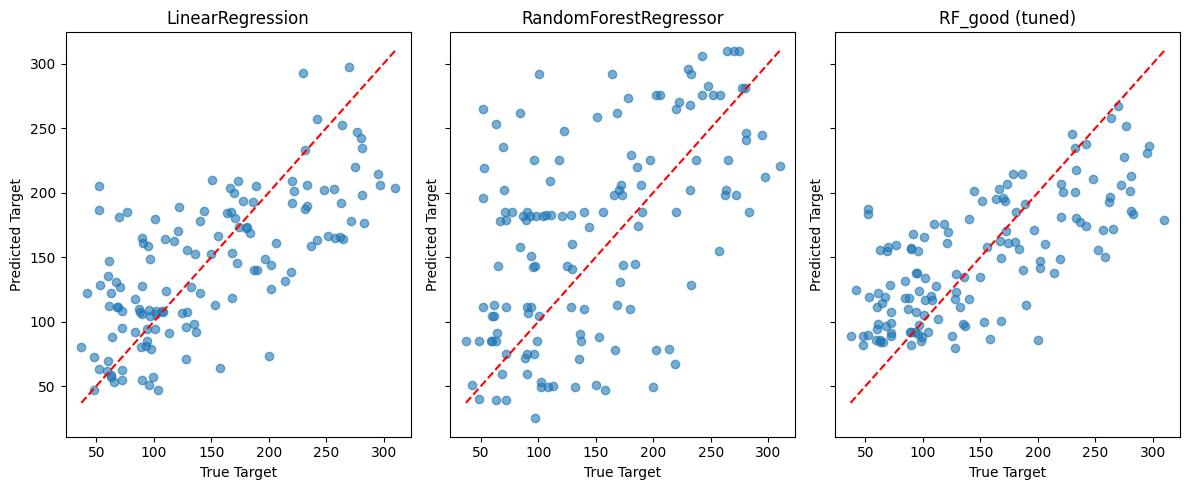

In [27]:
# 6. Plot true vs. predicted for both models
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
for ax, (name, y_pred) in zip(axes, predictions.items()):
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_title(name)
    ax.set_xlabel('True Target')
    ax.set_ylabel('Predicted Target')
plt.tight_layout()
plt.show()